In [1]:
import numpy as np
import cv2
from scipy.optimize import curve_fit
from google.colab.patches import cv2_imshow

# Processing information from the image

Traverse through all the pixels of the image and get the values with pixel values in a range of +/-2% error of required pixel value

### Coordinates of cyclone cores - Red 

In [2]:
def getCycloneCores(img):
  (x_dim, y_dim, z_dim) = img.shape 
  red_pixels = []
  cyclone_cores = []
  k=0
  for i in range(x_dim):
    for j in range(y_dim):
      if img[i,j,0]<10 and img[i,j,1]<10 and img[i,j,2]>220:
        k+=1
        red_pixels.append([i,j])

  temp = red_pixels[0]
  x = 0
  y = 0
  k = 0


  # Separating out coordinates of 2 cyclone cores (left and right) obtained from a single image from the set of red pixel coordinates obtained
  # Get centre value from the set of all coorinates obtained for a particular cyclone core to minimize angular deviation error later when line is to be formed

  for i in range(len(red_pixels)):
    if  red_pixels[i][0]-temp[0]<5 and red_pixels[i][1]-temp[1]<5:
      x += red_pixels[i][0]
      y += red_pixels[i][1]
      k += 1
    else:
      cyclone_cores.append([x/k,y/k])
      temp = red_pixels[i]
      x = red_pixels[i][0]
      y = red_pixels[i][1]
      k = 1
  cyclone_cores.append([x/k,y/k])

  print("The centre of cyclone cores are:", cyclone_cores)
  return cyclone_cores

### Coordinates of islands of Reunion and Mauritius - Blue

In [3]:
def getIslands(img):
  (x_dim, y_dim, z_dim) = img.shape
  blue_pixels = []
  islands = []

  for i in range(x_dim):
    for j in range(y_dim):
      if img[i,j,0]>220 and img[i,j,1]<10 and img[i,j,2]<10:
        blue_pixels.append([i,j])

  temp = blue_pixels[0]
  x = 0
  y = 0
  k = 0

  # Separating out coordinates of 2 islands obtained from a single image from the set of blue pixel coordinates obtained
  # Get centre value from the set of all coorinates obtained for a particular island to minimize angular deviation error later when line is to be formed
  
  for i in range(len(blue_pixels)):
    if  blue_pixels[i][0]-temp[0]<5 and blue_pixels[i][1]-temp[1]<5:
      x += blue_pixels[i][0]
      y += blue_pixels[i][1]
      k += 1
    else:
      islands.append([x/k,y/k])
      temp = blue_pixels[i]
      x = blue_pixels[i][0]
      y = blue_pixels[i][1]
      k = 1
  islands.append([x/k,y/k])

  print("The centre of islands of Reunion and Mauritius are:", islands)
  return islands

### Coordinates of Madagascar - Green

In [4]:
def getMadagascar(img):
  (x_dim, y_dim, z_dim) = img.shape
  green_pixels = []
  madagascar = []

  for i in range(x_dim):
    for j in range(y_dim):
      if img[i,j,0]<10 and img[i,j,1]>220 and img[i,j,2]<10:
        green_pixels.append([i,j])

  temp = green_pixels[0]
  x = 0
  y = 0
  k = 0

  # Separating out coordinates of 3 places on madagascar obtained from a single image from the set of green pixel coordinates obtained
  # Get centre value from the set of all coorinates obtained for a particular point on madagascar to minimize angular deviation error later when line is to be formed
  
  for i in range(len(green_pixels)):
    if  green_pixels[i][0]-temp[0]<5 and green_pixels[i][1]-temp[1]<5:
      x += green_pixels[i][0]
      y += green_pixels[i][1]
      k += 1
    else:
      madagascar.append([x/k,y/k])
      temp = green_pixels[i]
      x = green_pixels[i][0]
      y = green_pixels[i][1]
      k = 1
  madagascar.append([x/k,y/k])

  print("The coodinates of North and South of Madagascar are:", madagascar[0], "and", madagascar[2])
  print("The coodinates of Antananarivo are: ", madagascar[1])
  return madagascar

# Utility Functions

### Generate line given two points

Traverse through all the coordinates of the image and the slope of each coordinate with the slope of line formed by given two points. If difference between both slopes is less than a boundary value (2x10^-3 here) then consider it as a point on our required line

In [5]:
def getLinePoints(y1,x1,y2,x2,img):
  (x_dim, y_dim, z_dim) =  img.shape
  line = []
  m = (y2-y1)/(x2-x1)
  c = y1-m*x1
  for i in range(x_dim):
    for j in range(y_dim):
      if abs((i-y1)/(j-x1)-m)<2e-3 or abs((i-y2)/(j-x2)-m)<2e-3:
        line.append([i,j])
  return line

### Distance between two pixels

In [6]:
def dist(a,b):
  return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
  # return abs(a[0]-b[0]) + abs(a[1]-b[1])

### Quadratic curve fitting

In [7]:
def objective(x, a, b, c):
	return a * x + b * x**2 + c

### Plot all cyclone cores on a single image

In [8]:
def plot_all_cyclone_cores(cyclone_cores1, cyclone_cores2, cyclone_cores3, img):
  img = cv2.circle(img, (int(cyclone_cores1[0][1]),int(cyclone_cores1[0][0])), 2, (0, 100, 255), 2)
  img = cv2.circle(img, (int(cyclone_cores1[1][1]),int(cyclone_cores1[1][0])), 2, (0, 100, 255), 2)
  img = cv2.circle(img, (int(cyclone_cores3[0][1]),int(cyclone_cores3[0][0])), 2, (0, 100, 255), 2)
  img = cv2.circle(img, (int(cyclone_cores2[0][1]),int(cyclone_cores2[0][0])), 2, (0, 100, 255), 2)
  img = cv2.circle(img, (int(cyclone_cores3[1][1]),int(cyclone_cores3[1][0])), 2, (0, 100, 255), 2)
  img = cv2.circle(img, (int(cyclone_cores2[1][1]),int(cyclone_cores2[1][0])), 2, (0, 100, 255), 2)
  return img

### Intersection point of two lines

In [9]:
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False

# Main Code

## Read Image

Dimensions of given image:  (626, 940, 3)
The given 3 images are: 


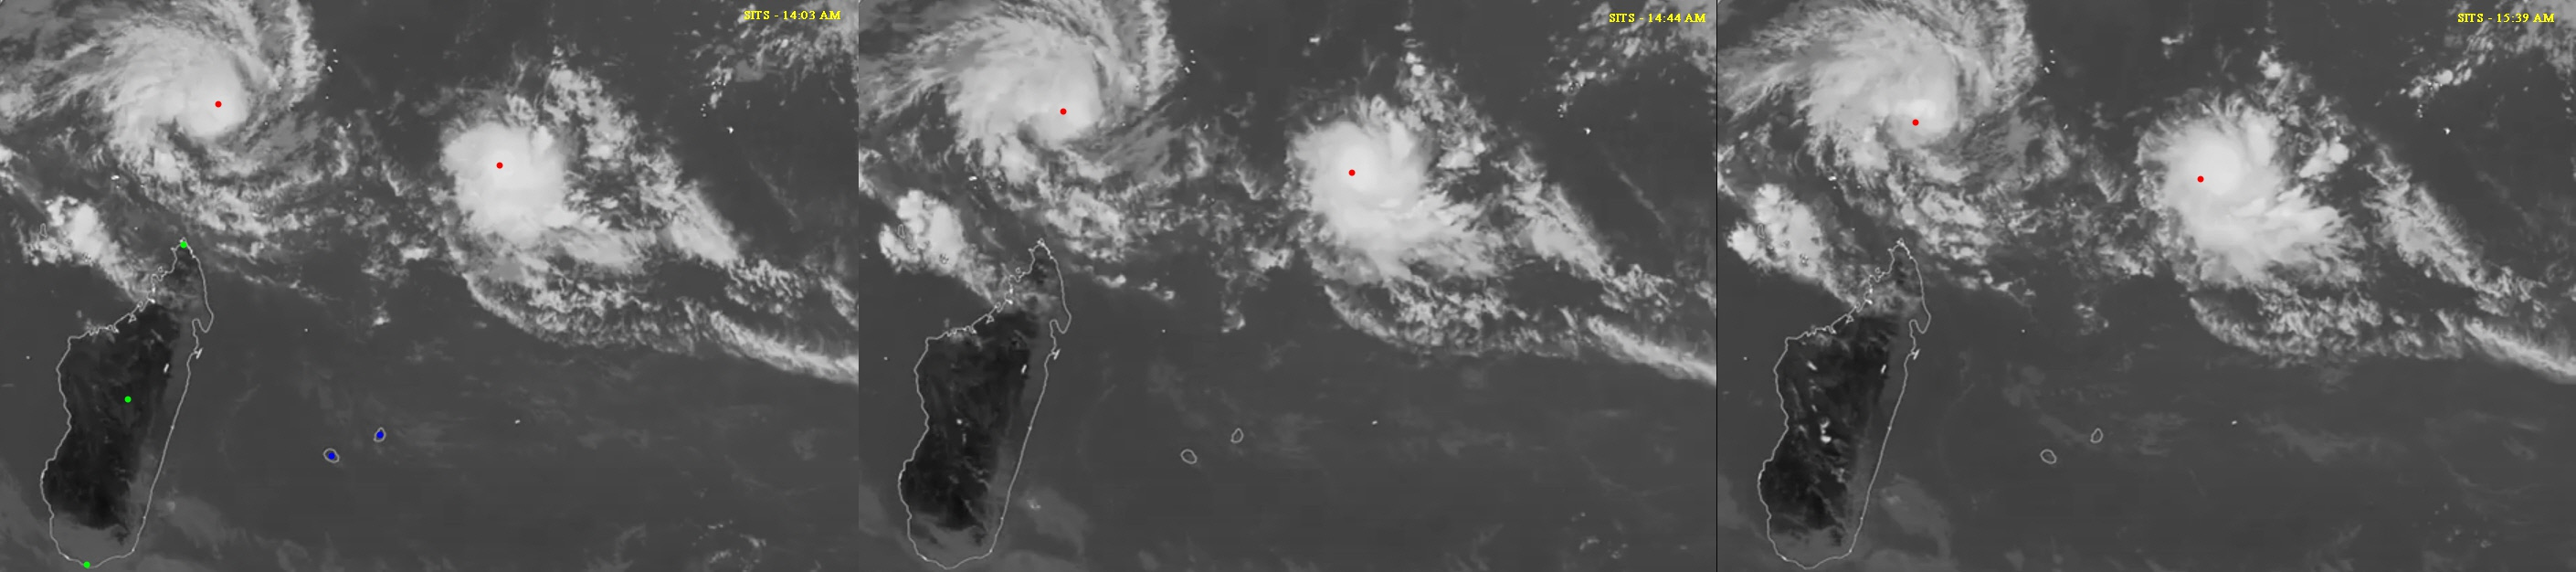

In [24]:
img1 = cv2.imread('/content/1.jpg')
img2 = cv2.imread('/content/2.jpg')
img3 = cv2.imread('/content/3.jpg')
(x_dim, y_dim, z_dim) = img1.shape
print("Dimensions of given image: ", img1.shape)


print("The given 3 images are: ")
Hor_imgs = np.concatenate((img1, img2, img3), axis=1)
cv2_imshow(Hor_imgs)

Get coordinates information from all the given images

In [11]:
islands = getIslands(img1)  # Blue
madagascar = getMadagascar(img1)  # Green
cyclone_cores1 = getCycloneCores(img1)  # Red
cyclone_cores2 = getCycloneCores(img2)
cyclone_cores3 = getCycloneCores(img3)

The centre of islands of Reunion and Mauritius are: [[475.5, 415.5], [498.7142857142857, 362.5]]
The coodinates of North and South of Madagascar are: [267.5, 200.5] and [617.5, 94.5]
The coodinates of Antananarivo are:  [436.5, 139.5]
The centre of cyclone cores are: [[113.63636363636364, 238.54545454545453], [180.36363636363637, 546.4545454545455]]
The centre of cyclone cores are: [[121.54545454545455, 223.63636363636363], [188.54545454545453, 539.3636363636364]]
The centre of cyclone cores are: [[133.5, 216.5], [195.5, 528.5]]


## Map kms to pixel distance

In [12]:
# kms/pixel_dist

factor1 = 250/(dist(islands[0],islands[1]))         # 250 kms -> The islands of Reunion and Mauritius (blue)
factor2 = 1500/dist(madagascar[0],madagascar[2])      # 1500 kms -> from north Antsiranana (green) to south Benonoka (green)
factor = (factor1+factor2)/2
print("Factor to convert pixel distance into kms: ",factor)

Factor to convert pixel distance into kms:  4.211212425395301


## Velocity

In [13]:
dist1 = dist(cyclone_cores2[0],cyclone_cores3[0])*factor
dist2 = dist(cyclone_cores2[1],cyclone_cores3[1])*factor
t = 55/60  # in hours       # 55 mins -> time interval between 2nd and 3rd snaps
vel1 = dist1/t  # in kmph
vel2 = dist2/t
print("Velocity of Belna: ", vel1," kmph")
print("Velocity of Ambali: ", vel2," kmph")

Velocity of Belna:  63.96112801162538  kmph
Velocity of Ambali:  59.25866708837001  kmph


## Solving the trajectory

### Case 1: Linear interpolation

The expected trajectory: Line joining the cyclone cores of latest two snaps of satellite

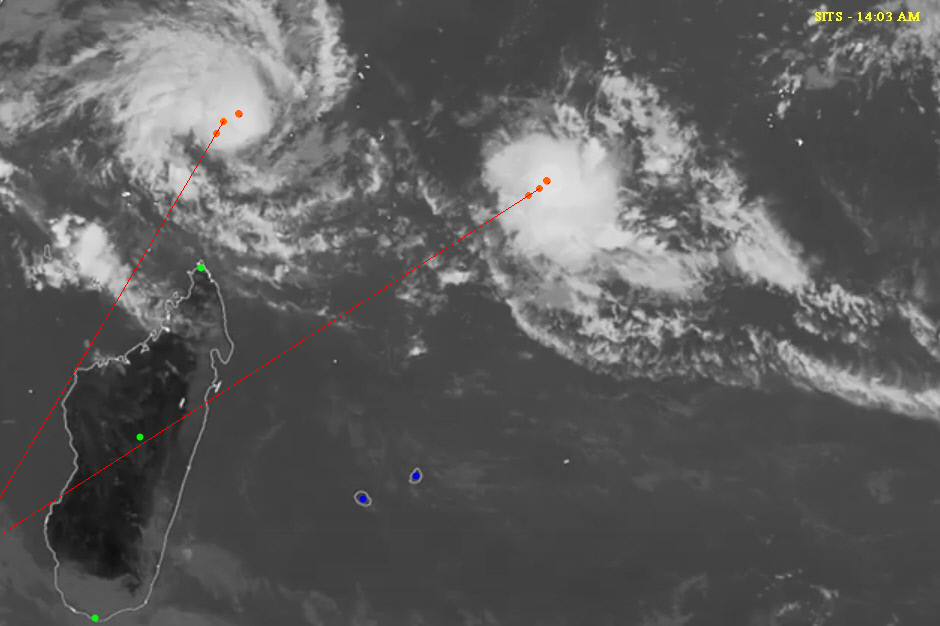

In [14]:
img4 = cv2.imread('/content/1.jpg')

img4 = plot_all_cyclone_cores(cyclone_cores1, cyclone_cores2, cyclone_cores3, img4)


# get points of the line joining cyclone cores 2 and 3
line1 = getLinePoints(cyclone_cores3[0][0],cyclone_cores3[0][1],cyclone_cores2[0][0],cyclone_cores2[0][1],img1)
line2 = getLinePoints(cyclone_cores3[1][0],cyclone_cores3[1][1],cyclone_cores2[1][0],cyclone_cores2[1][1],img1)

# make a line using first and last points got
len1 = len(line1)
len2 = len(line2)

img4 = cv2.line(img4, (int(cyclone_cores2[0][1]),int(cyclone_cores2[0][0])), (int(line1[len1-1][1]),int(line1[len1-1][0])), (0,0,255), 1)
img4 = cv2.line(img4, (int(cyclone_cores2[1][1]),int(cyclone_cores2[1][0])), (int(line2[len2-1][1]),int(line2[len2-1][0])), (0,0,255), 1)

cv2_imshow(img4)

Apocalyptic juncture (Apojuncture) -  The geographic place of their future trajectory intersection.

(Coordinates are according to the assumption that positive x-axis is rightwards and positive y-axis is downwards)

In [15]:
L1 = line((cyclone_cores2[0][1],cyclone_cores2[0][0]),(cyclone_cores2[1][1],cyclone_cores2[1][0]))
L1 = line(cyclone_cores2[0],cyclone_cores3[0])
L2 = line(cyclone_cores2[1],cyclone_cores3[1])

apoj = intersection(L1, L2)
print("Coordinates of Apojuncture: [", apoj[1],", ",apoj[0],"]")
# print(img4.shape)

Coordinates of Apojuncture: [ -36.383355649397124 ,  557.1198887630035 ]


Apojuncture shown in green out of the image on the left side

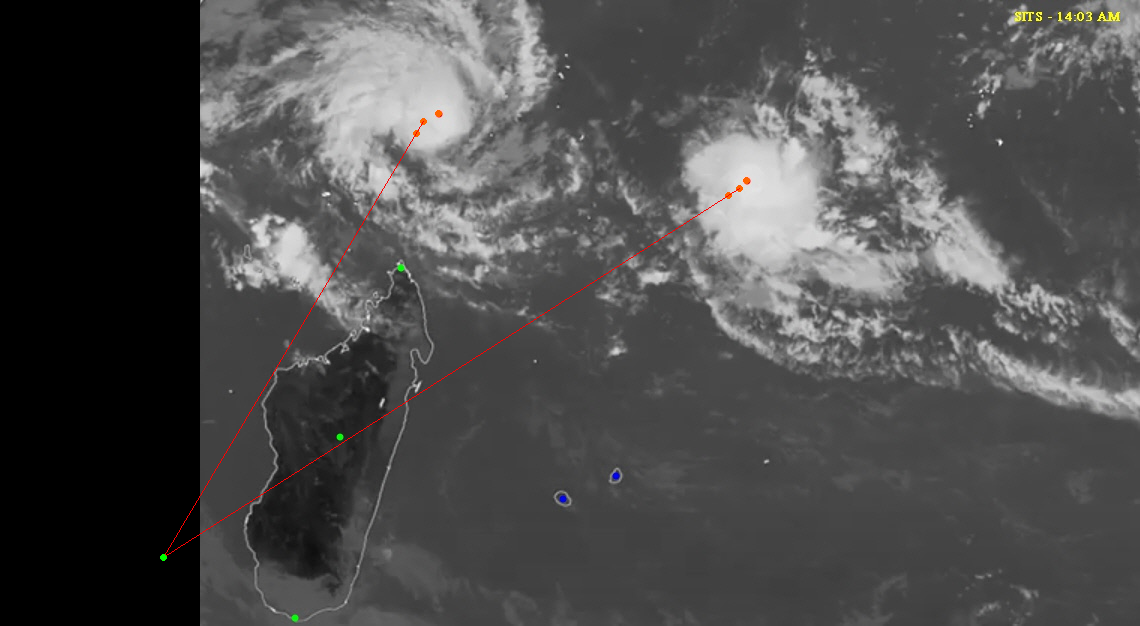

In [16]:
img4 = cv2.imread('/content/1.jpg')

img4 = plot_all_cyclone_cores(cyclone_cores1, cyclone_cores2, cyclone_cores3, img4)

ext_img = np.zeros((img4.shape[0], img4.shape[1]+200, 3), np.uint8)
# print(img4.shape)
ext_img[:,200:,:] = img4[:,:,:]
img4 = ext_img

img4 = cv2.line(img4, (int(cyclone_cores2[0][1]+200),int(cyclone_cores2[0][0])), (int(apoj[1]+200),int(apoj[0])), (0,0,255), 1)
img4 = cv2.line(img4, (int(cyclone_cores2[1][1]+200),int(cyclone_cores2[1][0])), (int(apoj[1]+200),int(apoj[0])), (0,0,255), 1)

img4 = cv2.circle(img4, (int(apoj[1]+200),int(apoj[0])), 2, (0,255,0) ,2)

cv2_imshow(img4)

### Results

 How far (in Km) the apojuncture will be from the capital city?

In [17]:
print("Distance of apojuncture from Antananarivo is: ", dist(apoj,madagascar[1])*factor," kms")

Distance of apojuncture from Antananarivo is:  898.1254660887955  kms


 When will it occur (how many hours after the last satellite image capture)? 

In [18]:
t1 = dist(cyclone_cores3[0],apoj)*factor/vel1
t2 = dist(cyclone_cores3[1],apoj)*factor/vel2

print("Time after which apojuncture occurs: ",t2," hrs")    # since t2>t1

Time after which apojuncture occurs:  47.66449514196442  hrs


 Will they actually collide in reality?

In [19]:
# print(t1,t2)
if abs(t1-t2)<1/60:
  print("YES, they will collide in reality")
else:
  print("NO, they won't collide in relaity")

NO, they won't collide in relaity


### Summary


*   Velocity of Belna:  63.96112801162538 kmph
*   Velocity of Ambali:  59.25866708837001 kmph
*   Distance of apojuncture from Antananarivo is:  898.1254660887955  kms
*   Time after which apojuncture occurs:  47.66449514196442  hrs
*   NO, they won't collide in reality



### Case 2: Quadratic interpolation

51


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


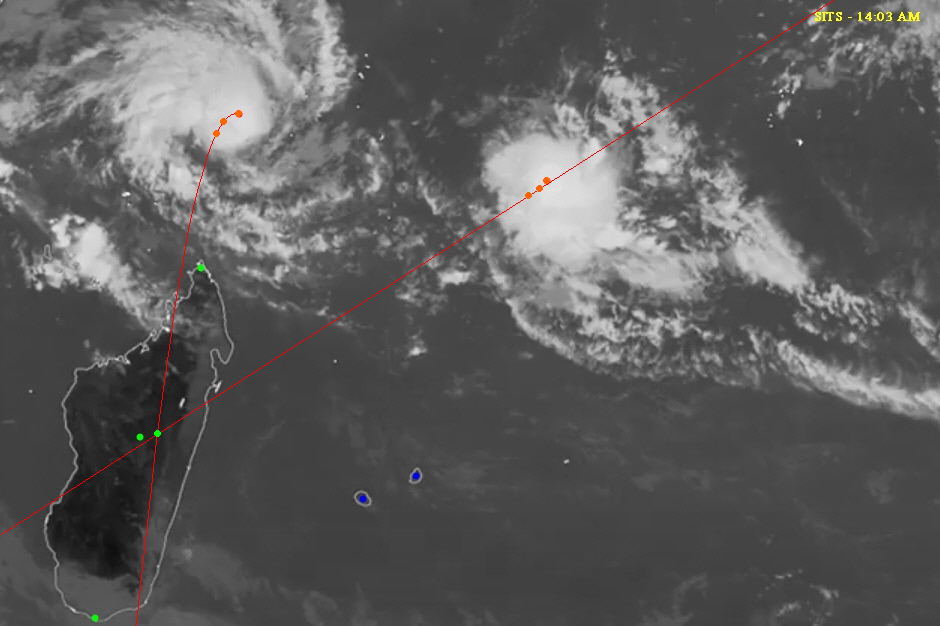

In [20]:
y = np.array([cyclone_cores1[0][0],cyclone_cores2[0][0],cyclone_cores3[0][0]])
x = np.array([cyclone_cores1[0][1],cyclone_cores2[0][1],cyclone_cores3[0][1]])
fitting_parameters, _ = curve_fit(objective, x, y)
a, b, c = fitting_parameters

x_min = 0
x_max = y_dim                      # min/max values for x axis
x_fit = np.linspace(x_min, x_max, 200)   # range of x values used for the fit function
y_fit = objective(x_fit, *fitting_parameters)

img4 = cv2.imread('/content/1.jpg')

for i in range(1,int(len(x_fit))):
	# img4 = cv2.circle(img4, (int(x_fit[i]),int(y_fit[i])), 3, (0,0,255) ,-1)
	img4 = cv2.line(img4, (int(x_fit[i]),int(y_fit[i])), (int(x_fit[i-1]),int(y_fit[i-1])), (0,0,255), 1)
	if x_fit[i]>=cyclone_cores1[0][1]:
		print(i)
		break

img4 = cv2.line(img4, (int(line2[0][1]),int(line2[0][0])), (int(line2[len2-1][1]),int(line2[len2-1][0])), (0,0,255), 1)

img4 = plot_all_cyclone_cores(cyclone_cores1, cyclone_cores2, cyclone_cores3, img4)

apoj2 = [433,157]
img4 = cv2.circle(img4, (157,433), 2, (0,255,0) ,2)

cv2_imshow(img4)

Apocalyptic juncture (Apojuncture) - The geographic place of their future trajectory intersection.

(Coordinates are according to the assumption that positive x-axis is rightwards and positive y-axis is downwards)

In [21]:
print("Coordinates of Apojuncture: [", apoj2[1],", ",apoj2[0],"]")

Coordinates of Apojuncture: [ 157 ,  433 ]


### Results

How far (in Km) the apojuncture will be from the capital city?

In [22]:
print("Distance of apojuncture from Antananarivo is: ", dist(apoj2,madagascar[1])*factor," kms")

Distance of apojuncture from Antananarivo is:  75.15569016541264  kms


When will it occur (how many hours after the last satellite image capture)?

In [23]:
t1 = dist(cyclone_cores3[0],apoj2)*factor/vel1
t2 = dist(cyclone_cores3[1],apoj2)*factor/vel2
# print(t1,t2)
print("Time after which apojuncture occurs: ",t2," hrs")    # since t2>t1 significantly, even if we calculate along quadratic path t2>t1

Time after which apojuncture occurs:  31.334593457398963  hrs


Will they actually collide in reality?

t1 calculated according to quadratic path is still much lower than t2. i.e. their difference is still greater than atleast 1hr (abs(t1-t2)>1hr). So they might not collide even in this case.

### Summary


*   Velocity of Belna:  63.96112801162538 kmph
*   Velocity of Ambali:  59.25866708837001 kmph
*   Distance of apojuncture from Antananarivo is:  75.15569016541264  kms
*   Time after which apojuncture occurs:  31.334593457398963  hrs
*   NO, they won't collide in reality

